In [1]:
from glob import glob

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nilearn.plotting import plot_design_matrix

%load_ext autoreload
%autoreload 1
%aimport simulation_code

from simulation_code import (
    create_design_matrix,
    est_contrast_vifs,
    load_event_files,
    make_desmat_sub,
    make_desmat_sub_nilearn,
)

# Code checks

Here I'm simply verifying a few questions I had about the code I'm using to generate the design matrices.  Briefly, using Nilearn to perform convolution is very slow compared to convolution code we have used in other work.  So far, I haven't needed to run a simulation study, but in case I do, I wanted to be sure the VIFs I obtain with the code base we've used for simulations in the past are similar to the VIFs when using the Nilearn design matrices, since that is what will be used in practice.  It turns out this can make a difference, since Michael and I had previously calculated efficiencies using different design matrix construction and we had noticeable differences that were related to the time resolution used for convolution (the oversampling rate).

## Code check 1 (this one didn't really end up mattering, but I wanted to save the code)
The original design matrices modeled response time using a parametric modulation, but we should be using duration, so I'm regenerating the design matrix for the main regressors, but pulling the nuisance regressors out of the original.

Just spot checking that regressors from my approach match the original design matrix (aside from the RT regressor)

In [2]:
events_files = glob('../data/event_files/*modified_surveyMedley_events.tsv')
sub_ids = [ef.split('/')[-1].split('_')[0] for ef in events_files]

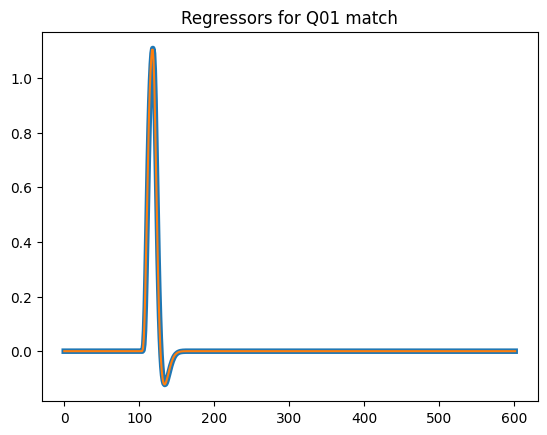

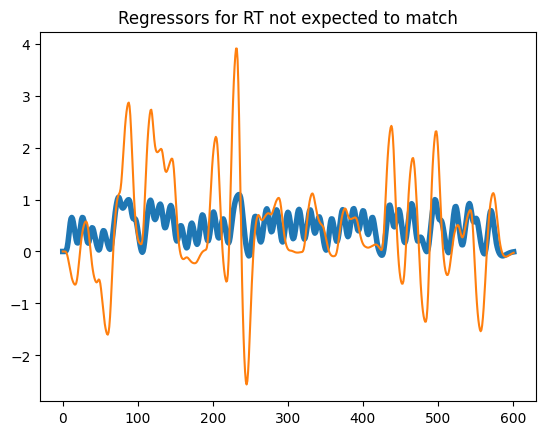

In [3]:
my_des568 = make_desmat_sub('568')
orig_des568 = pd.read_csv(
    '../data/simplified_events_rt/sub-568_task-surveyMedley_design-matrix.csv'
)
orig_des568.drop(columns=['Unnamed: 0'], inplace=True)

plt.plot(my_des568['Q01'], linewidth=4)
plt.plot(orig_des568['Q01'])
plt.title('Regressors for Q01 match')
plt.show()

plt.plot(my_des568['rt'], linewidth=4)
plt.plot(orig_des568['response_time'])
plt.title('Regressors for RT not expected to match')
plt.show()

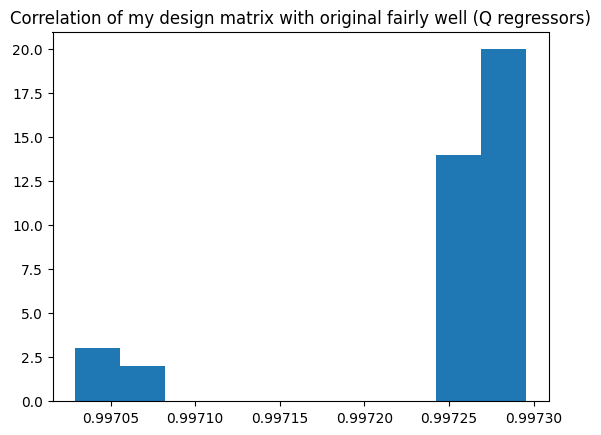

In [4]:
question_columns = [col for col in my_des568.columns if 'Q' in col]
cor_assess = {'Q': [], 'correlation': []}

for col in question_columns:
    cor = my_des568[col].corr(orig_des568[col])
    cor_assess['Q'].append(col)
    cor_assess['correlation'].append(cor)

cor_assess_df = pd.DataFrame(cor_assess)

plt.hist(cor_assess_df['correlation'], bins=10)
plt.title('Correlation of my design matrix with original fairly well (Q regressors)')
plt.show()

### Infinite VIFs when RT-modulated regressor was used
Note the `num_*` regressors are omitted here and `response_time` is an RT-modulated regressor that uses the same duration as the Q regressors.

In [5]:
orig_des568 = pd.read_csv(
    '../data/simplified_events_rt/sub-568_task-surveyMedley_design-matrix.csv'
)

X = orig_des568.loc[
    :,
    ~orig_des568.columns.str.contains('Unnamed: 0|derivative|num|cosine03|cosine04'),
]

print(X.columns)

## using the new VIF tool
contrasts = {col_name: col_name for col_name in X.columns if 'Q' in col_name}
print('new VIF')
print(est_contrast_vifs(X, contrasts))

Index(['Q01', 'Q02', 'Q03', 'Q04', 'Q05', 'Q06', 'Q07', 'Q08', 'Q09', 'Q10',
       'Q11', 'Q12', 'Q13', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31',
       'Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40',
       'cosine00', 'cosine01', 'cosine02', 'trans_x', 'trans_x_power2',
       'trans_y', 'trans_y_power2', 'trans_z', 'trans_z_power2', 'rot_x',
       'rot_x_power2', 'rot_y', 'rot_y_power2', 'rot_z', 'rot_z_power2',
       'response_time', 'constant'],
      dtype='object')
new VIF
            Q01           Q02           Q03           Q04           Q05  \
0  1.091350e+15  1.900276e+13  9.936584e+13  3.139893e+13  5.817949e+14   

            Q06           Q07           Q08           Q09           Q10  ...  \
0  1.157518e+15  4.914166e+13  8.057374e+12  3.712484e+13  5.586333e+13  ...   

            Q31           Q32           Q33           Q34           Q35  \
0  6.803578e+14  1.140645e

## Code check: compare VIFS `make_first_level_design_matrix` to my desmats

In the case that I run simulations in the future, Nilearn is too slow for generating design matrices and so I'll likely use my own code instead.  I am verifying the VIFs are similar between the two.

There are very small differences.  To be on the safe side, I should stick to Nilearn when possible when constructing design matrices.  Since it is only about 100 subjects, it may be fine for my purposes, even if I do end up running simulations.


In [6]:
vifs_nilearn = []
vifs_mycode = []

for sub_id in sub_ids:
    subnum = sub_id[-3:]
    desmat_sub = make_desmat_sub_nilearn(subnum)
    desmat_sub_mycode = make_desmat_sub(subnum)

    if desmat_sub is not None and desmat_sub_mycode is not None:
        desmat_sub = desmat_sub.loc[
            :,
            ~desmat_sub.columns.str.contains('num|response_time|cosine03|cosine04'),
        ]
        desmat_sub_mycode = desmat_sub_mycode.loc[
            :,
            ~desmat_sub_mycode.columns.str.contains(
                'num|response_time|cosine03|cosine04'
            ),
        ]
        contrasts = {
            col_name: col_name for col_name in desmat_sub.columns if 'Q' in col_name
        }
        vifs_nilearn_loop = est_contrast_vifs(desmat_sub, contrasts)
        vifs_mycode_loop = est_contrast_vifs(desmat_sub_mycode, contrasts)
        vifs_nilearn.append(vifs_nilearn_loop)
        vifs_mycode.append(vifs_mycode_loop)

Error for subnum 618 
 from make_first_level_design_matrix: Matrix is singular at working precision, regularizing...


In [7]:
print(desmat_sub.columns)
print(desmat_sub_mycode.columns)

Index(['Q01', 'Q02', 'Q03', 'Q04', 'Q05', 'Q06', 'Q07', 'Q08', 'Q09', 'Q10',
       'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20',
       'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30',
       'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40',
       'rt_duration', 'constant', 'cosine00', 'cosine01', 'cosine02',
       'trans_x', 'trans_x_derivative1', 'trans_x_power2',
       'trans_x_derivative1_power2', 'trans_y', 'trans_y_derivative1',
       'trans_y_derivative1_power2', 'trans_y_power2', 'trans_z',
       'trans_z_derivative1', 'trans_z_power2', 'trans_z_derivative1_power2',
       'rot_x', 'rot_x_derivative1', 'rot_x_derivative1_power2',
       'rot_x_power2', 'rot_y', 'rot_y_derivative1',
       'rot_y_derivative1_power2', 'rot_y_power2', 'rot_z',
       'rot_z_derivative1', 'rot_z_power2', 'rot_z_derivative1_power2'],
      dtype='object')
Index(['Q01', 'Q02', 'Q03', 'Q04', 'Q05', 'Q06', 'Q07', 'Q08', 'Q09', 'Q10'

In [8]:
vifs_nilearn_all = pd.concat(vifs_nilearn)
vifs_nilearn_all['model'] = 'nilearn'
vifs_mycode_all = pd.concat(vifs_mycode)
vifs_mycode_all['model'] = 'mycode'
vifs_all = pd.concat([vifs_nilearn_all, vifs_mycode_all])

vifs_long = pd.melt(vifs_all, var_name='Q', value_name='vif', id_vars=['model'])

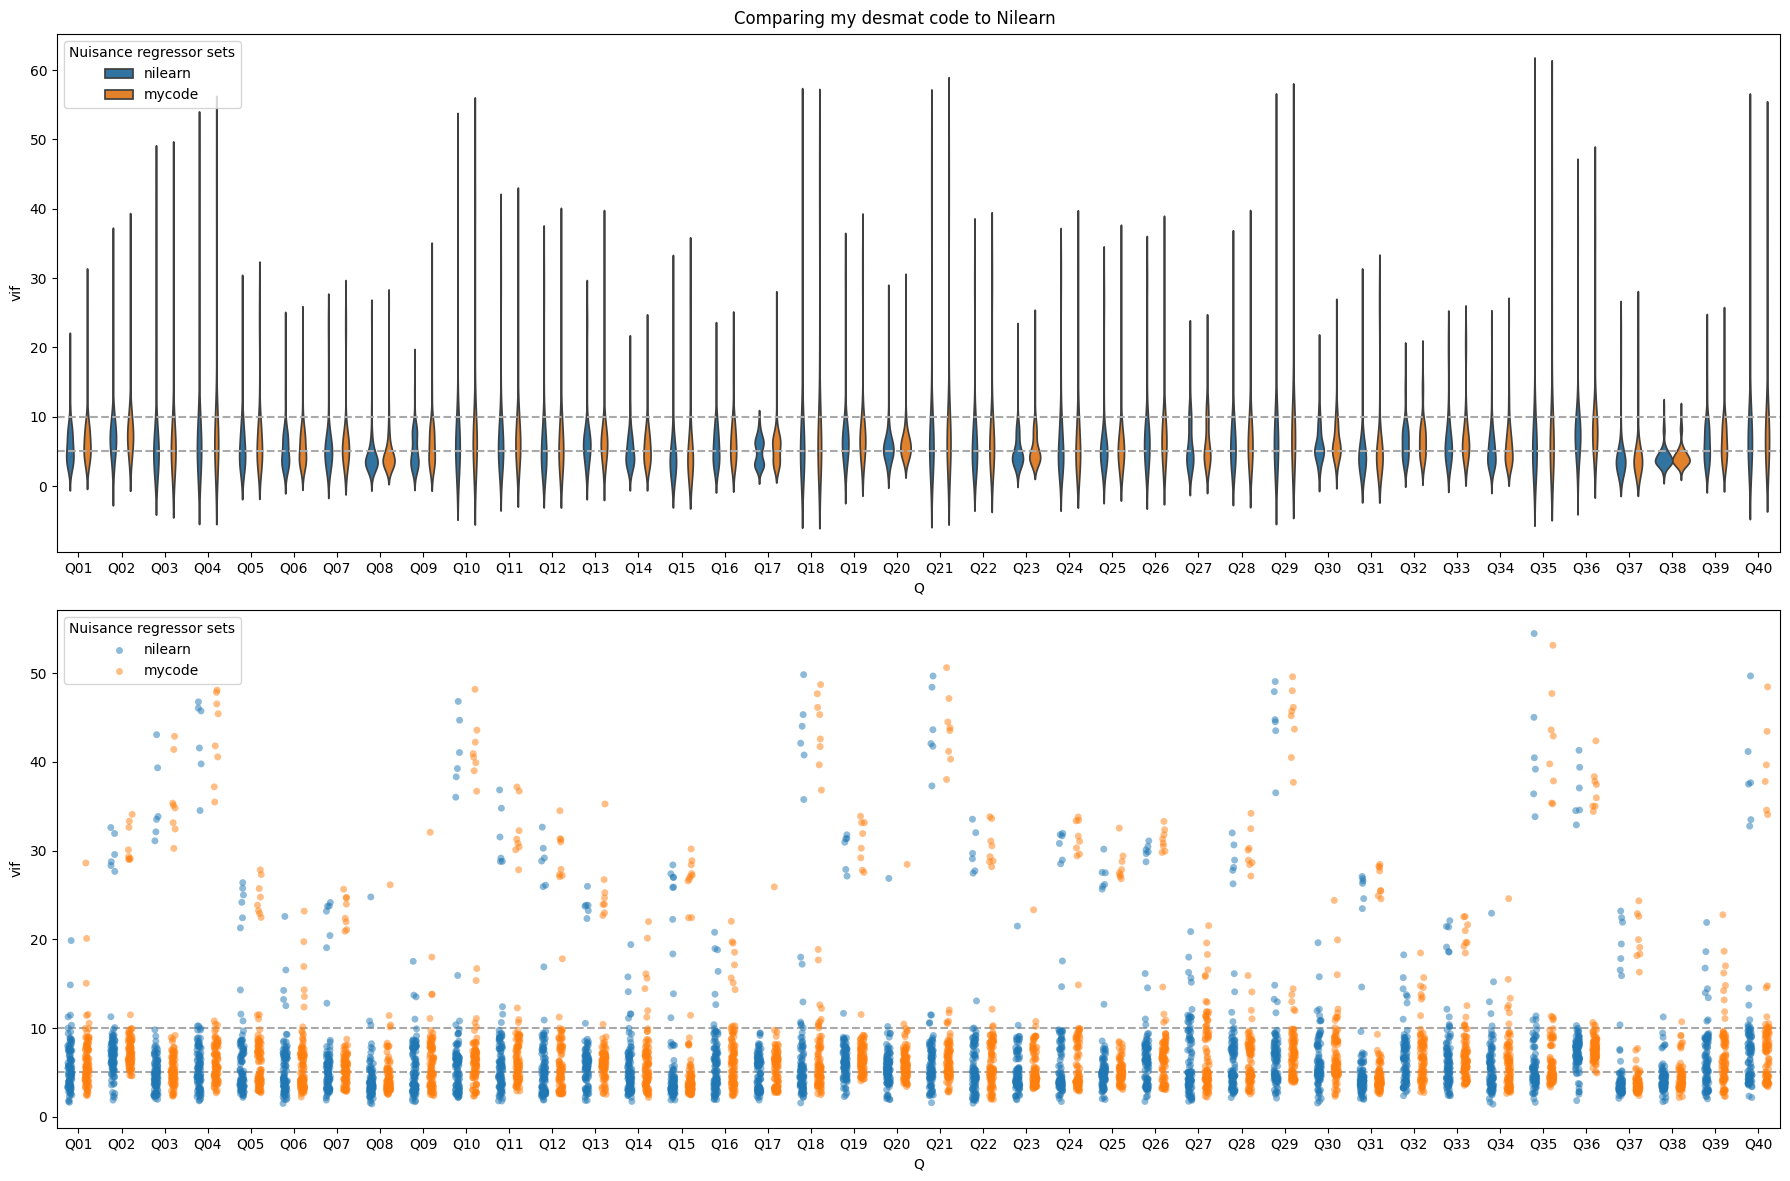

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(18, 12))
fig.suptitle('Comparing my desmat code to Nilearn')

sns.violinplot(x='Q', y='vif', hue='model', data=vifs_long, inner=None, ax=axes[0])
axes[0].axhline(5, color='darkgray', linestyle='--')
axes[0].axhline(10, color='darkgray', linestyle='--')
axes[0].legend(title='Nuisance regressor sets', loc='upper left')

sns.stripplot(
    x='Q', y='vif', data=vifs_long, hue='model', dodge=True, alpha=0.5, ax=axes[1]
)
axes[1].legend(title='Nuisance regressor sets', loc='upper left')
axes[1].axhline(5, color='darkgray', linestyle='--')
axes[1].axhline(10, color='darkgray', linestyle='--')

plt.tight_layout()
plt.show()